# Final Project

Team members: Soren Bear, Ben Hertzberg, Cristian Hohbein, Ryan Quon

### **Title:** Effect of Education, Income Level, and Access to Healthcare on Racial Disparity in Voter Turnout

### **Question:** How do education, income level, and access to healthcare compare in their effect on racial disparity in voter turnout, both across and within racial categories?

In [56]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

To make things easier on myself I will just do the analysis on Maine, but it should be easily scaled.

In [57]:
ME_pq_path = 'gs://pstat135-bh/notebooks/jupyter/FinalProject/VM2Uniform--ME--2021-05-28'
df2 = spark.read.format('parquet').load('gs://pstat135-bh/notebooks/jupyter/FinalProject/VM2Uniform--ME--2021-05-28')


Interesting columns from EDA:

In [58]:
interesting_cols = [
    'LALVOTERID',
    'Voters_Active',
    'Voters_VotingPerformanceEvenYearGeneral',
    'Voters_VotingPerformanceEvenYearPrimary', 
    'Voters_VotingPerformanceEvenYearGeneralAndPrimary',
    'Voters_VotingPerformanceMinorElection',
    'Voters_Gender',
    'Voters_Age',
    'Parties_Description',
    'VoterParties_Change_Changed_Party',
    'Ethnic_Description',
    'EthnicGroups_EthnicGroup1Desc',
    'CountyEthnic_Description',
    'CountyEthnic_LALEthnicCode',
    'Religions_Description',
    'Health_District',
    'High_School_District',
    'Hospital_District',
    'Library_District',
    'Middle_School_District',
    'Sanitary_District',
    'School_Board_District',
    'School_District',
    'Sewer_District',
    'Unified_School_District',
    'Vote_By_Mail_Area',
    'CommercialData_Education',
    'CommercialData_AreaMedianEducationYears',
    'CommercialData_EstHomeValue',
    'CommercialData_LandValue',
    'CommercialData_StateIncomeDecile',
    'CommercialData_EstimatedHHIncome',
    'CommercialData_EstimatedHHIncomeAmount',
    'CommercialData_EstimatedAreaMedianHHIncome',
    'CommercialDataLL_HH_Net_Worth',
    'CommercialData_ISPSA'
]

Read tab-delimited files (inferring schema) and keep only interesting columns:

In [59]:
# de_df = spark.read.format('csv')\
#     .option('header', 'true')\
#     .option('inferSchema', 'true')\
#     .option('delimiter', '\t')\
#     .load(de_tab)

# hi_df = spark.read.format('csv')\
#     .option('header', 'true')\
#     .option('inferSchema', 'true')\
#     .option('delimiter', '\t')\
#     .load(hi_tab)

# me_df = spark.read.format('csv')\
#     .option('header', 'true')\
#     .option('inferSchema', 'true')\
#     .option('delimiter', '\t')\
#     .load(me_tab)

# de_df = de_df.select(*interesting_cols)
# hi_df = hi_df.select(*interesting_cols)
me_df = df2.select(*interesting_cols)

Union into one big DataFrame:

In [60]:
all_df = me_df #change this to union of all dfs used in final analysis

In [61]:
all_df.printSchema()

root
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_VotingPerformanceEvenYearGeneral: string (nullable = true)
 |-- Voters_VotingPerformanceEvenYearPrimary: string (nullable = true)
 |-- Voters_VotingPerformanceEvenYearGeneralAndPrimary: string (nullable = true)
 |-- Voters_VotingPerformanceMinorElection: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- VoterParties_Change_Changed_Party: string (nullable = true)
 |-- Ethnic_Description: string (nullable = true)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- CountyEthnic_Description: string (nullable = true)
 |-- CountyEthnic_LALEthnicCode: string (nullable = true)
 |-- Religions_Description: string (nullable = true)
 |-- Health_District: string (nullable = true)
 |-- High_School_District: string (nullable = true)
 |-- Hospital_District: string (null

These all seem reasonable. The only integer categories are `Voters_Age`, `CommercialData_AreaMedianEducationYears`, `CommercialData_StateIncomeDecile` and `CommercialData_ISPSA`. Other categories may benefit from being converted into integer types later in the project. For EDA, they are fine as-is.

Repartition and cache:

In [62]:
all_df = all_df.repartition(20)
all_df.cache()

23/03/23 05:15:31 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


DataFrame[LALVOTERID: string, Voters_Active: string, Voters_VotingPerformanceEvenYearGeneral: string, Voters_VotingPerformanceEvenYearPrimary: string, Voters_VotingPerformanceEvenYearGeneralAndPrimary: string, Voters_VotingPerformanceMinorElection: string, Voters_Gender: string, Voters_Age: string, Parties_Description: string, VoterParties_Change_Changed_Party: string, Ethnic_Description: string, EthnicGroups_EthnicGroup1Desc: string, CountyEthnic_Description: string, CountyEthnic_LALEthnicCode: string, Religions_Description: string, Health_District: string, High_School_District: string, Hospital_District: string, Library_District: string, Middle_School_District: string, Sanitary_District: string, School_Board_District: string, School_District: string, Sewer_District: string, Unified_School_District: string, Vote_By_Mail_Area: string, CommercialData_Education: string, CommercialData_AreaMedianEducationYears: string, CommercialData_EstHomeValue: string, CommercialData_LandValue: string,

In [63]:
#drop columns we decided were not useful
cols_to_drop = ['CountyEthnic_LALEthnicCode', 'CountyEthnic_Description', 'Ethnic_Description']
all_df = all_df.drop(*cols_to_drop)

## Section on Missingness

In [64]:
missing = [(c, all_df.where(col(c).isNull()).count()) for c in all_df.columns]    #Get missing counts of all intersting variables
missing = pd.DataFrame(missing).rename(columns = {0:'Variable Name', 1:'Missing Count'})

In [65]:
missing

,Variable Name,Missing Count
0,LALVOTERID,0
1,Voters_Active,0
2,Voters_VotingPerformanceEvenYearGeneral,0
3,Voters_VotingPerformanceEvenYearPrimary,0
4,Voters_VotingPerformanceEvenYearGeneralAndPrimary,0
5,Voters_VotingPerformanceMinorElection,0
6,Voters_Gender,8435
7,Voters_Age,1728
8,Parties_Description,0
9,VoterParties_Change_Changed_Party,1018811


Count records:

In [66]:
total = all_df.count()

In [67]:
#find ratio of missingness/total count for all variables
missing['Percent Missing'] = missing['Missing Count']/total
missing.head(10)

,Variable Name,Missing Count,Percent Missing
0,LALVOTERID,0,0.000000
1,Voters_Active,0,0.000000
2,Voters_VotingPerformanceEvenYearGeneral,0,0.000000
3,Voters_VotingPerformanceEvenYearPrimary,0,0.000000
4,Voters_VotingPerformanceEvenYearGeneralAndPrimary,0,0.000000
5,Voters_VotingPerformanceMinorElection,0,0.000000
6,Voters_Gender,8435,0.008107
7,Voters_Age,1728,0.001661
8,Parties_Description,0,0.000000
9,VoterParties_Change_Changed_Party,1018811,0.979200


In [68]:
#let's see what variables have over 50% missingness, because we might not be able to use them
missing[missing['Percent Missing']>0.5]

,Variable Name,Missing Count,Percent Missing
9,VoterParties_Change_Changed_Party,1018811,0.979200
11,Religions_Description,640839,0.615924
12,Health_District,1040452,1.000000
13,High_School_District,1040452,1.000000
14,Hospital_District,1040452,1.000000
15,Library_District,1040452,1.000000
16,Middle_School_District,1040452,1.000000
17,Sanitary_District,1040452,1.000000
18,School_Board_District,1040452,1.000000
19,School_District,1040452,1.000000


At least for the state of Maine, no data was collected on districts (school districts, hospital districts, etc), so I will drop these variables. No vote by mail data was collected either. Information on voter party change is nearly entirely missing as well, and won't be useful in analysis. Data on religion and net worth is mostly missing, so I will ignore them for now, but there may be enough non missing values in these variables for some limited analysis down the road.

In [69]:
missing[missing['Percent Missing']<0.5].sort_values(by =['Percent Missing'], ascending = False).head()

,Variable Name,Missing Count,Percent Missing
26,CommercialData_LandValue,493004,0.473836
23,CommercialData_Education,431346,0.414576
32,CommercialData_ISPSA,122220,0.117468
30,CommercialData_EstimatedAreaMedianHHIncome,122220,0.117468
27,CommercialData_StateIncomeDecile,122220,0.117468


Of the remaining variables, CommercialData_LandValue and CommercialData_Education have over 40% missingness, so I will ignore them for now as well. However, these two can be used for limited analysis later on as well. CommercialData_ISPSA, CommercialData_EstimatedAreaMedianHHIncome, CommercialData_StateIncomeDecile, and CommercialData_AreaMedianEducationYears all contain 11.7468% missingness, and I assume that means they are all missing from the same records. I think if I replace these null values with a placeholder (such as -1), the majority of records will still contain meaningfull information across all of these columns. In fact, I will use such a placeholder for all variables containing missingness, except for the ethnic group variable.

I will drop the records containing missing values in the Ethnic group variable, because that information is key to all our planned analysis.

In [70]:
all_df = all_df.fillna(value = {'CommercialData_ISPSA':'-1', 
                                 'CommercialData_EstimatedAreaMedianHHIncome': '-1', 
                                 'CommercialData_StateIncomeDecile':'-1', 
                                 'CommercialData_AreaMedianEducationYears':'-1',
                                 'CommercialData_EstHomeValue': '-1',
                                 'CommercialData_EstimatedHHIncome':'-1',
                                 'CommercialData_EstimatedHHIncomeAmount':'-1',
                                 'Voters_Gender':'-1', 
                                 'Voters_Age':'-1'})


In [71]:
drop_cols = missing[missing['Percent Missing']>0.5].iloc[:, 0]
all_df2 = all_df.drop(*drop_cols)
all_df2 = all_df2.drop('CommercialData_LandValue', 'CommercialData_Education')
# all_df2 = all_df2.dropna(subset = 'EthnicGroups_EthnicGroup1Desc') #drop na values from the ethnic group column


In [72]:
missing2 = [(c, all_df2.where(col(c).isNull()).count()) for c in all_df2.columns]    #Get missing counts of all intersting variables
missing2


[('LALVOTERID', 0),
 ('Voters_Active', 0),
 ('Voters_VotingPerformanceEvenYearGeneral', 0),
 ('Voters_VotingPerformanceEvenYearPrimary', 0),
 ('Voters_VotingPerformanceEvenYearGeneralAndPrimary', 0),
 ('Voters_VotingPerformanceMinorElection', 0),
 ('Voters_Gender', 0),
 ('Voters_Age', 0),
 ('Parties_Description', 0),
 ('EthnicGroups_EthnicGroup1Desc', 81594),
 ('CommercialData_AreaMedianEducationYears', 0),
 ('CommercialData_EstHomeValue', 0),
 ('CommercialData_StateIncomeDecile', 0),
 ('CommercialData_EstimatedHHIncome', 0),
 ('CommercialData_EstimatedHHIncomeAmount', 0),
 ('CommercialData_EstimatedAreaMedianHHIncome', 0),
 ('CommercialData_ISPSA', 0)]

In [73]:
missing2 = pd.DataFrame(missing2).rename(columns = {0:'Variable Name', 1:'Missing Count'})
total = all_df.count()
#find ratio of missingness/total count for all variables
missing2['Percent Missing'] = missing2['Missing Count']/total
missing2.sort_values(by =['Percent Missing'], ascending = False)

,Variable Name,Missing Count,Percent Missing
9,EthnicGroups_EthnicGroup1Desc,81594,0.078422
0,LALVOTERID,0,0.000000
15,CommercialData_EstimatedAreaMedianHHIncome,0,0.000000
14,CommercialData_EstimatedHHIncomeAmount,0,0.000000
13,CommercialData_EstimatedHHIncome,0,0.000000
12,CommercialData_StateIncomeDecile,0,0.000000
11,CommercialData_EstHomeValue,0,0.000000
10,CommercialData_AreaMedianEducationYears,0,0.000000
8,Parties_Description,0,0.000000
1,Voters_Active,0,0.000000


In [74]:
all_df2 = all_df2.dropna()
total2 = all_df2.count()
total2/total
#check how much data we retained after removing records with missing ethnic group values


0.9215783140404362

## Section on Column Conversion

In [75]:
all_df2.select('Voters_VotingPerformanceMinorElection').show(12)
#must be careful when handling voting performance data, because some entries have 'Not Eligible' instead of a percentage

+-------------------------------------+
|Voters_VotingPerformanceMinorElection|
+-------------------------------------+
|                                   0%|
|                                   0%|
|                                  10%|
|                                  10%|
|                                   0%|
|                                   0%|
|                                   0%|
|                                  10%|
|                                   0%|
|                                  10%|
|                                   0%|
|                         Not Eligible|
+-------------------------------------+
only showing top 12 rows



In [76]:
all_df2.where(col('Voters_VotingPerformanceMinorElection') == 'Not Eligible').count()
#for now I will input a 0% for 'Not Eligible', because it still means the voter did not participate

76632

In [77]:
votingPerformanceCols = ['Voters_VotingPerformanceEvenYearGeneral',
                         'Voters_VotingPerformanceEvenYearPrimary',
                         'Voters_VotingPerformanceEvenYearGeneralAndPrimary',
                         'Voters_VotingPerformanceMinorElection'
                        ]
all_df2 = all_df2.replace('Not Eligible', '0%', votingPerformanceCols)

In [78]:
all_df2 = all_df2.withColumn('CommercialData_EstHomeValue', regexp_replace('CommercialData_EstHomeValue', '[$,]', '').cast('double'))
all_df2 = all_df2.withColumn('CommercialData_EstimatedHHIncomeAmount', regexp_replace('CommercialData_EstimatedHHIncomeAmount', '[$,]', '').cast('double'))
all_df2 = all_df2.withColumn('CommercialData_EstimatedAreaMedianHHIncome', regexp_replace('CommercialData_EstimatedAreaMedianHHIncome', '[$,]', '').cast('double'))
all_df2 = all_df2.withColumn('Voters_Age', regexp_replace('Voters_Age', '[$,]', '').cast('double'))
all_df2 = all_df2.withColumn('CommercialData_AreaMedianEducationYears', regexp_replace('CommercialData_AreaMedianEducationYears', '[$,]', '').cast('double'))
all_df2 = all_df2.withColumn('Voters_VotingPerformanceEvenYearGeneral', regexp_replace('Voters_VotingPerformanceEvenYearGeneral', '[%,]', '').cast('double')/100)
all_df2 = all_df2.withColumn('Voters_VotingPerformanceEvenYearPrimary', regexp_replace('Voters_VotingPerformanceEvenYearPrimary', '[%,]', '').cast('double')/100)
all_df2 = all_df2.withColumn('Voters_VotingPerformanceEvenYearGeneralAndPrimary', regexp_replace('Voters_VotingPerformanceEvenYearGeneralAndPrimary', '[%,]', '').cast('double')/100)
all_df2 = all_df2.withColumn('Voters_VotingPerformanceMinorElection', regexp_replace('Voters_VotingPerformanceMinorElection', '[%,]', '').cast('double')/100)
all_df2.printSchema()
all_df2.show(10, False)


root
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_VotingPerformanceEvenYearGeneral: double (nullable = true)
 |-- Voters_VotingPerformanceEvenYearPrimary: double (nullable = true)
 |-- Voters_VotingPerformanceEvenYearGeneralAndPrimary: double (nullable = true)
 |-- Voters_VotingPerformanceMinorElection: double (nullable = true)
 |-- Voters_Gender: string (nullable = false)
 |-- Voters_Age: double (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: double (nullable = true)
 |-- CommercialData_EstHomeValue: double (nullable = true)
 |-- CommercialData_StateIncomeDecile: string (nullable = false)
 |-- CommercialData_EstimatedHHIncome: string (nullable = false)
 |-- CommercialData_EstimatedHHIncomeAmount: double (nullable = true)
 |-- CommercialData_EstimatedAreaMedianHHIncome: double (nullable = true)
 |-- Commerc

## Start of some Regression

In [ ]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula='Voters_Active ~ Education_Combined + CommercialData_StateIncomeDecile')

all_df3 = all_df2.drop('LALVOTERID')

In [79]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="Voters_Active ~ .")

all_df3 = all_df2.drop('LALVOTERID')

In [80]:
fittedRF = supervised.fit(all_df3)
preparedDF = fittedRF.transform(all_df3)

In [81]:
preparedDF.show(2, truncate = False)


+-------------+---------------------------------------+---------------------------------------+-------------------------------------------------+-------------------------------------+-------------+----------+-------------------+-----------------------------+---------------------------------------+---------------------------+--------------------------------+--------------------------------+--------------------------------------+------------------------------------------+--------------------+--------------------------------------------------------------------------------------------------------------+-----+
|Voters_Active|Voters_VotingPerformanceEvenYearGeneral|Voters_VotingPerformanceEvenYearPrimary|Voters_VotingPerformanceEvenYearGeneralAndPrimary|Voters_VotingPerformanceMinorElection|Voters_Gender|Voters_Age|Parties_Description|EthnicGroups_EthnicGroup1Desc|CommercialData_AreaMedianEducationYears|CommercialData_EstHomeValue|CommercialData_StateIncomeDecile|CommercialData_EstimatedHHIn

In [82]:
colsDF = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"] 
["attrs"]["binary"]+preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

colsDF

,idx,name
43,0,Voters_VotingPerformanceEvenYearGeneral
44,1,Voters_VotingPerformanceEvenYearPrimary
45,2,Voters_VotingPerformanceEvenYearGeneralAndPrimary
46,3,Voters_VotingPerformanceMinorElection
0,4,Voters_Gender_F
1,5,Voters_Gender_M
47,6,Voters_Age
2,7,Parties_Description_Democratic
3,8,Parties_Description_Non-Partisan
4,9,Parties_Description_Republican


In [83]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 619)

In [84]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label",featuresCol="features")

In [85]:
lrModel = lr.fit(train)

In [86]:
print(lrModel.coefficients)

[-0.5344677069700567,-0.19588466860613024,-0.4772601881127767,-0.45930062632288127,-0.02050946559950772,-0.15822160086565568,-0.015295097811177877,1.1954658848805872,1.1571294497109113,1.2129897736481805,1.2389371858683733,-0.1595943390616574,0.7023788223247973,0.6376101390161659,0.7220481761353411,0.45517459822503503,-0.0636646752088109,-6.409090042034476e-07,-1.112557649715356,-0.16386060749030115,-0.13446883294907888,-0.3019442896292133,-0.07839937912997118,-0.17084141592725952,-0.11105757779326084,0.29742700663589056,-0.09476687312220962,-0.040593248177415095,-0.07223076349706128,-0.1306295581231198,-0.11364547998357681,-0.3987310730289385,0.4348946880500395,-0.17686824595496334,-0.3675784458342035,-0.03450062543549318,-0.09252808046676295,0.007533939140602311,0.292486022176299,0.055743028375484005,-4.346281149100086e-06,5.622280652466245e-06,-1.112557649715356,0.06587565536950334,0.13122778272017369,0.0911772308197138,0.008800699396224097,-0.03864495795625254,-0.01177639323963474,

In [87]:
print(lrModel.intercept)

-2.401704186585904


In [88]:
array = np.array(lrModel.coefficients)
coefficients = pd.DataFrame(array, columns = ['coefficient'])

merged = colsDF.merge(coefficients, left_index = True, right_index = True)

merged.reindex(merged['coefficient'].abs().sort_values(ascending=False).index)


,idx,name,coefficient
10,15,EthnicGroups_EthnicGroup1Desc_East and South A...,1.238937e+00
9,14,EthnicGroups_EthnicGroup1Desc_Other,1.212990e+00
7,12,EthnicGroups_EthnicGroup1Desc_European,1.195466e+00
8,13,EthnicGroups_EthnicGroup1Desc_Hispanic and Por...,1.157129e+00
42,51,CommercialData_ISPSA_1,-1.112558e+00
18,25,CommercialData_StateIncomeDecile_0,-1.112558e+00
14,21,CommercialData_StateIncomeDecile_7,7.220482e-01
12,19,CommercialData_StateIncomeDecile_9,7.023788e-01
13,20,CommercialData_StateIncomeDecile_8,6.376101e-01
0,4,Voters_Gender_F,-5.344677e-01


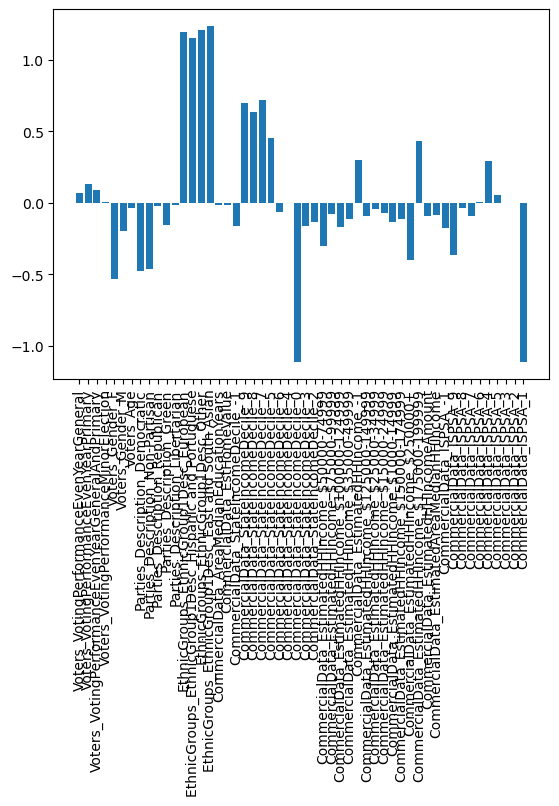

In [89]:
plt.bar(merged['name'], merged['coefficient'])
plt.xticks(rotation='vertical')
plt.show()

In [90]:
fittedTest = lrModel.transform(test)


In [91]:
fittedTest.select(['label', 'prediction', 'rawPrediction']).show()


+-----+----------+--------------------+
|label|prediction|       rawPrediction|
+-----+----------+--------------------+
|  0.0|       0.0|[2.03616384072811...|
|  0.0|       0.0|[2.71037685274040...|
|  0.0|       0.0|[2.72227317304632...|
|  0.0|       0.0|[2.71115145862756...|
|  0.0|       0.0|[4.34284633440220...|
|  0.0|       0.0|[2.09117946607367...|
|  0.0|       0.0|[2.38148392002529...|
|  0.0|       0.0|[2.54090142355351...|
|  0.0|       0.0|[2.87690562135563...|
|  0.0|       0.0|[3.48709673028038...|
|  0.0|       0.0|[2.66672903080364...|
|  0.0|       0.0|[2.58038452474024...|
|  0.0|       0.0|[2.23563041843121...|
|  0.0|       0.0|[1.90468896160540...|
|  0.0|       0.0|[2.21810652966361...|
|  0.0|       0.0|[1.70197716265600...|
|  0.0|       0.0|[1.37881684109521...|
|  0.0|       0.0|[1.47864085110751...|
|  0.0|       0.0|[2.06163017971753...|
|  0.0|       0.0|[3.57133295489056...|
+-----+----------+--------------------+
only showing top 20 rows



In [92]:
all_df4 = all_df3.drop('CommercialData_EstimatedHHIncome',
                       'CommercialData_EstimatedHHIncomeAmount',
                       'CommercialData_EstimatedAreaMedianHHIncome',
                       'CommercialData_ISPSA')
fittedRF2 = supervised.fit(all_df4)
preparedDF2 = fittedRF2.transform(all_df4)
preparedDF2.show(2, truncate = False)


+-------------+---------------------------------------+---------------------------------------+-------------------------------------------------+-------------------------------------+-------------+----------+-------------------+-----------------------------+---------------------------------------+---------------------------+--------------------------------+--------------------------------------------------------------------------+-----+
|Voters_Active|Voters_VotingPerformanceEvenYearGeneral|Voters_VotingPerformanceEvenYearPrimary|Voters_VotingPerformanceEvenYearGeneralAndPrimary|Voters_VotingPerformanceMinorElection|Voters_Gender|Voters_Age|Parties_Description|EthnicGroups_EthnicGroup1Desc|CommercialData_AreaMedianEducationYears|CommercialData_EstHomeValue|CommercialData_StateIncomeDecile|features                                                                  |label|
+-------------+---------------------------------------+---------------------------------------+-----------------------

In [93]:
colsDF2 = pd.DataFrame(preparedDF2.schema["features"].metadata["ml_attr"] 
["attrs"]["binary"]+preparedDF2.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

colsDF2

,idx,name
21,0,Voters_VotingPerformanceEvenYearGeneral
22,1,Voters_VotingPerformanceEvenYearPrimary
23,2,Voters_VotingPerformanceEvenYearGeneralAndPrimary
24,3,Voters_VotingPerformanceMinorElection
0,4,Voters_Gender_F
1,5,Voters_Gender_M
25,6,Voters_Age
2,7,Parties_Description_Democratic
3,8,Parties_Description_Non-Partisan
4,9,Parties_Description_Republican


In [94]:
train2, test2 = preparedDF2.randomSplit([0.7, 0.3], seed = 619)

In [95]:
lrModel2 = lr.fit(train2)

In [96]:
array2 = np.array(lrModel2.coefficients)
coefficients2 = pd.DataFrame(array2, columns = ['coefficient'])

merged2 = colsDF2.merge(coefficients2, left_index = True, right_index = True)

merged2.reindex(merged2['coefficient'].abs().sort_values(ascending=False).index)


,idx,name,coefficient
18,25,CommercialData_StateIncomeDecile_0,-1.318120
10,15,EthnicGroups_EthnicGroup1Desc_East and South A...,0.926190
9,14,EthnicGroups_EthnicGroup1Desc_Other,0.891825
7,12,EthnicGroups_EthnicGroup1Desc_European,0.886734
8,13,EthnicGroups_EthnicGroup1Desc_Hispanic and Por...,0.840992
0,4,Voters_Gender_F,-0.596200
14,21,CommercialData_StateIncomeDecile_7,0.594125
12,19,CommercialData_StateIncomeDecile_9,0.552132
13,20,CommercialData_StateIncomeDecile_8,0.505349
3,8,Parties_Description_Non-Partisan,-0.463857


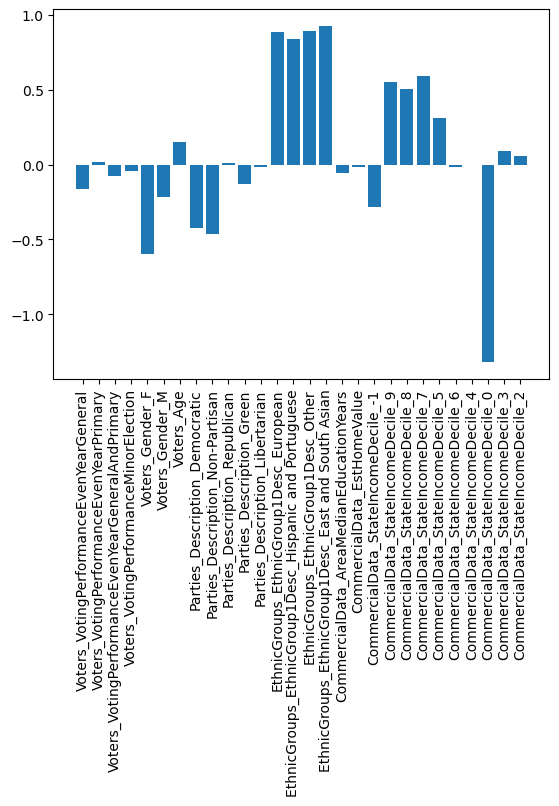

In [97]:
plt.bar(merged2['name'], merged2['coefficient'])
plt.xticks(rotation='vertical')
plt.show()

In [98]:
summary = lrModel.summary
summary.areaUnderROC


0.6782882455407809

In [99]:
summary2 = lrModel2.summary


In [2]:
summary2.areaUnderROC


NameError: name 'summary2' is not defined

In [1]:

EastAndSouthAsianDF = all_df4[all_df4['EthnicGroups_EthnicGroup1Desc'] == 'East and South Asian']
EuropeanDF = all_df4[all_df4['EthnicGroups_EthnicGroup1Desc'] == 'European']
OtherDF = all_df4[all_df4['EthnicGroups_EthnicGroup1Desc'] == 'Other']
HispanicAndPortugueseDF = all_df4[all_df4['EthnicGroups_EthnicGroup1Desc']== 'Hispanic and Portuguese']
LikelyAfricanAmericanDF = all_df4[all_df4['EthnicGroups_EthnicGroup1Desc']== ' Likely African American']

NameError: name 'all_df4' is not defined

In [102]:
EastAndSouthAsianDF.show(5)

+-------------+---------------------------------------+---------------------------------------+-------------------------------------------------+-------------------------------------+-------------+----------+-------------------+-----------------------------+---------------------------------------+---------------------------+--------------------------------+
|Voters_Active|Voters_VotingPerformanceEvenYearGeneral|Voters_VotingPerformanceEvenYearPrimary|Voters_VotingPerformanceEvenYearGeneralAndPrimary|Voters_VotingPerformanceMinorElection|Voters_Gender|Voters_Age|Parties_Description|EthnicGroups_EthnicGroup1Desc|CommercialData_AreaMedianEducationYears|CommercialData_EstHomeValue|CommercialData_StateIncomeDecile|
+-------------+---------------------------------------+---------------------------------------+-------------------------------------------------+-------------------------------------+-------------+----------+-------------------+-----------------------------+----------------------

In [103]:
EastAndSouthAsianDF = EastAndSouthAsianDF.drop('EthnicGroups_EthnicGroup1Desc')

In [104]:
fittedRF3 = supervised.fit(EastAndSouthAsianDF)
preparedDF3 = fittedRF3.transform(EastAndSouthAsianDF)
preparedDF3.show(2, truncate = False)

+-------------+---------------------------------------+---------------------------------------+-------------------------------------------------+-------------------------------------+-------------+----------+-------------------+---------------------------------------+---------------------------+--------------------------------+--------------------------------------------------------------------+-----+
|Voters_Active|Voters_VotingPerformanceEvenYearGeneral|Voters_VotingPerformanceEvenYearPrimary|Voters_VotingPerformanceEvenYearGeneralAndPrimary|Voters_VotingPerformanceMinorElection|Voters_Gender|Voters_Age|Parties_Description|CommercialData_AreaMedianEducationYears|CommercialData_EstHomeValue|CommercialData_StateIncomeDecile|features                                                            |label|
+-------------+---------------------------------------+---------------------------------------+-------------------------------------------------+-------------------------------------+-------

In [105]:
colsDF3 = pd.DataFrame(preparedDF3.schema["features"].metadata["ml_attr"] 
["attrs"]["binary"]+preparedDF3.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

colsDF3

,idx,name
15,0,Voters_VotingPerformanceEvenYearGeneral
16,1,Voters_VotingPerformanceEvenYearPrimary
17,2,Voters_VotingPerformanceEvenYearGeneralAndPrimary
18,3,Voters_VotingPerformanceMinorElection
0,4,Voters_Gender_F
1,5,Voters_Gender_M
19,6,Voters_Age
2,7,Parties_Description_Democratic
3,8,Parties_Description_Non-Partisan
4,9,Parties_Description_Republican


In [106]:
train3, test3 = preparedDF3.randomSplit([0.7, 0.3], seed = 619)

In [107]:
lrModel3 = lr.fit(train3)

In [108]:
array3 = np.array(lrModel3.coefficients)
coefficients3 = pd.DataFrame(array3, columns = ['coefficient'])

merged3 = colsDF3.merge(coefficients3, left_index = True, right_index = True)

merged3.reindex(merged3['coefficient'].abs().sort_values(ascending=False).index)


,idx,name,coefficient
13,20,CommercialData_StateIncomeDecile_2,-2.298296e+00
2,7,Parties_Description_Democratic,-1.592982e+00
16,1,Voters_VotingPerformanceEvenYearPrimary,-7.678004e-01
18,3,Voters_VotingPerformanceMinorElection,-6.666897e-01
21,11,CommercialData_EstHomeValue,-6.635935e-01
0,4,Voters_Gender_F,6.499712e-01
1,5,Voters_Gender_M,6.463731e-01
8,15,CommercialData_StateIncomeDecile_8,5.164992e-01
17,2,Voters_VotingPerformanceEvenYearGeneralAndPrimary,-4.888749e-01
12,19,CommercialData_StateIncomeDecile_6,-4.248086e-01


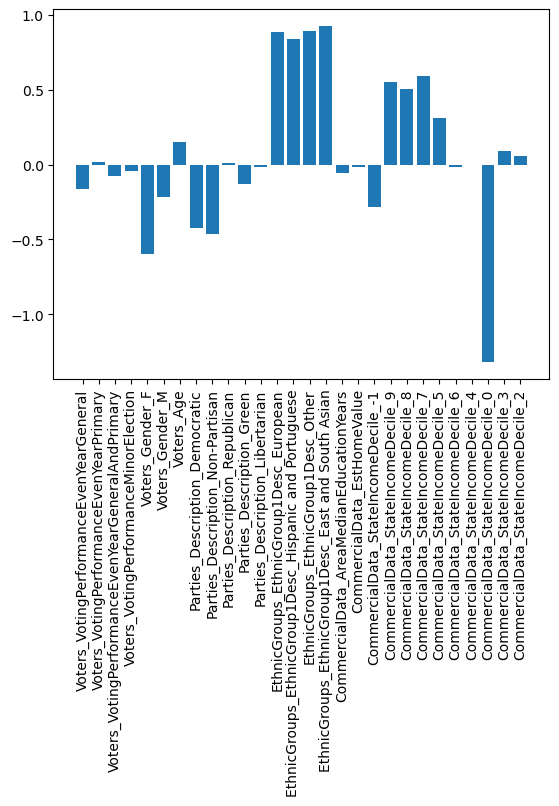

In [109]:
plt.bar(merged2['name'], merged2['coefficient'])
plt.xticks(rotation='vertical')
plt.show()

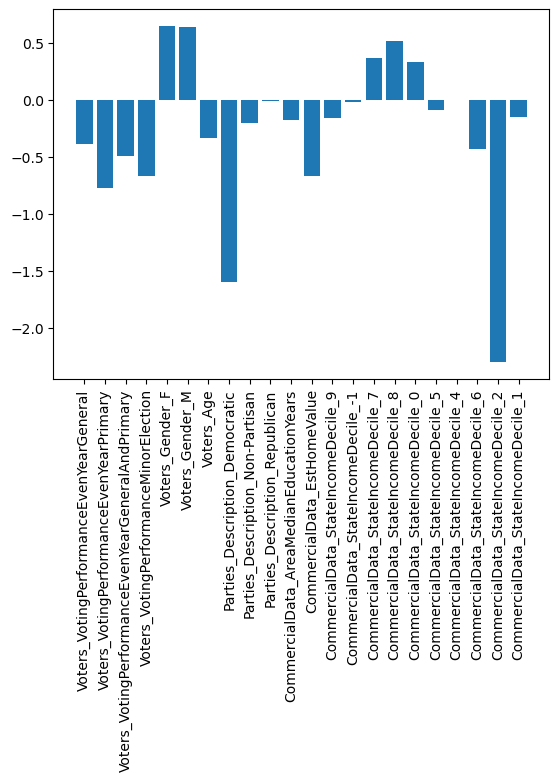

In [110]:
plt.bar(merged3['name'], merged3['coefficient'])
plt.xticks(rotation='vertical')
plt.show()